# XGBoost Tuning (Descriptors)

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna

## Molecule, Descriptor and Outlier Functions

In [228]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped

## Dataset Processing

In [229]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.80
# Correlation threshold
CORRELATION_THRESHOLD = 0.90

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build descriptors
descriptor_rows = []
state_molecules = []
molecules = []

# Loop over the SMILES column
for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # If molecule construction failed - empty placeholder
    if molecule is None:
        descriptor_rows.append({})
        continue
    # Calculate descriptors for each molecule
    descriptor_rows.append(calculate_descriptors(molecule))

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 230
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labute

## Base Model Train

In [230]:
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42
)
# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.5758
Precision: 0.6250
Recall:    0.5556
F1 score:  0.5882
ROC AUC:   0.7148

Classification report:
              precision    recall  f1-score   support

           0      0.529     0.600     0.562        15
           1      0.625     0.556     0.588        18

    accuracy                          0.576        33
   macro avg      0.577     0.578     0.575        33
weighted avg      0.582     0.576     0.577        33



## Feature Selection

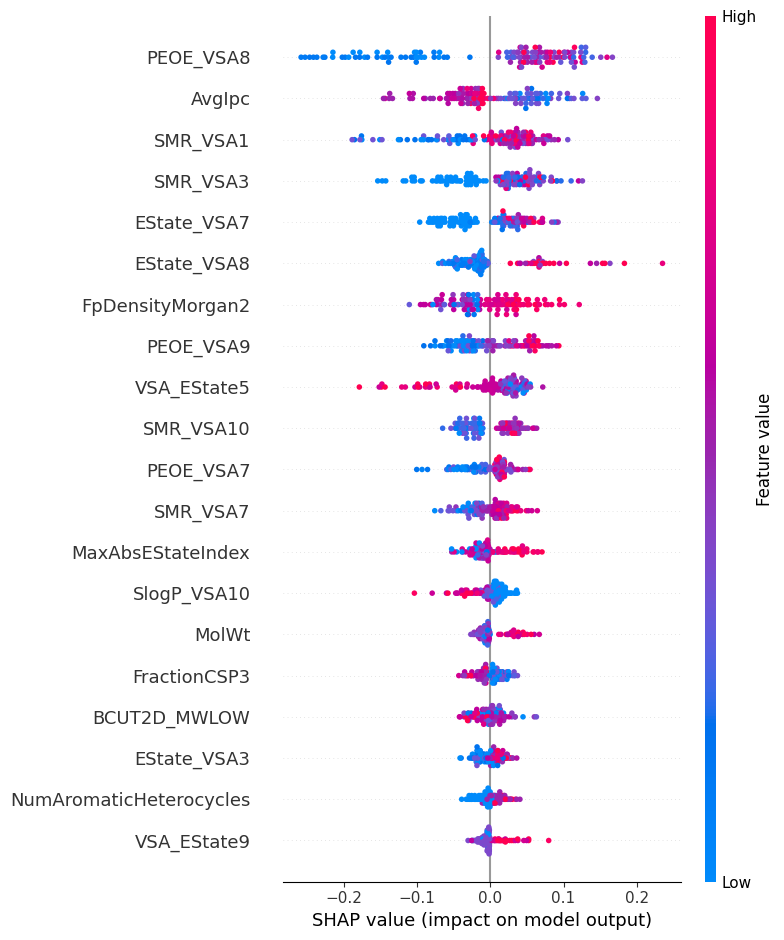

In [231]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# XGBoost features
xgb_importance = pd.Series(base_model.feature_importances_, index=X_train.columns)
xgb_features = xgb_importance.sort_values(ascending=False)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

## SHAP Features


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.744000  0.749845    0.808150
1      6     0.767077  0.773936    0.838553
2      7     0.744308  0.756132    0.836996
3      8     0.728000  0.736171    0.817766
4      9     0.743692  0.751332    0.821337

Best number of features by CV F1: 6
Top_N          6.000000
CV_Accuracy    0.767077
CV_F1          0.773936
CV_ROC_AUC     0.838553
Name: 1, dtype: float64


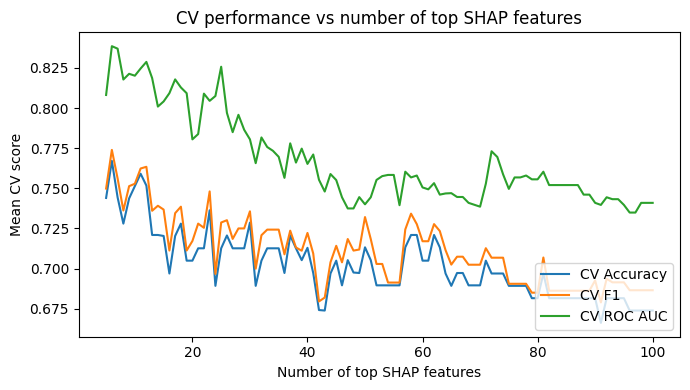

In [232]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1):
    top_feats = shap_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## XGB Features


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.728615  0.739713    0.787912
1      6     0.705231  0.710083    0.775641
2      7     0.697231  0.712553    0.764652
3      8     0.673846  0.689290    0.752289
4      9     0.704615  0.723233    0.774725

Best number of features by CV F1: 15
Top_N          15.000000
CV_Accuracy     0.728615
CV_F1           0.754627
CV_ROC_AUC      0.782967
Name: 10, dtype: float64


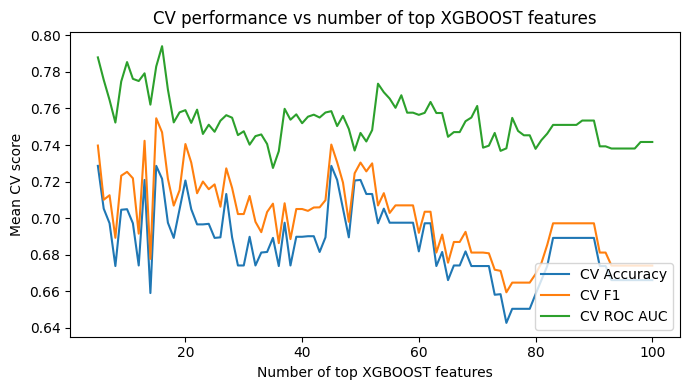

In [233]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(xgb_features) + 1):
    top_feats = xgb_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_xgb = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top XGBOOST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top XGBOOST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.721538  0.747561    0.753663
1      6     0.713846  0.737840    0.779579
2      7     0.728923  0.754601    0.767857
3      8     0.720923  0.738089    0.758974
4      9     0.720923  0.732269    0.789835

Best number of features by CV F1: 26
Top_N          26.000000
CV_Accuracy     0.736923
CV_F1           0.757647
CV_ROC_AUC      0.786996
Name: 21, dtype: float64


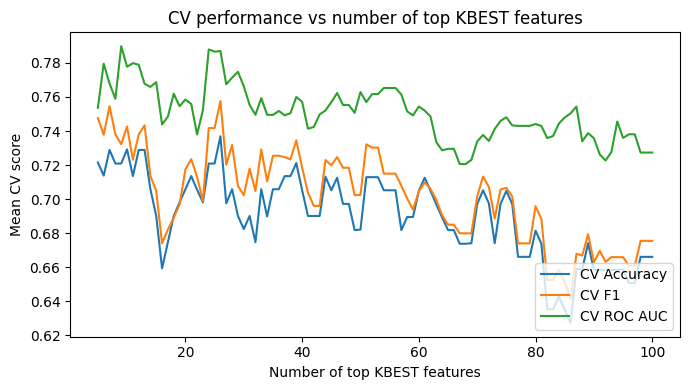

In [234]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1):
    top_feats = kbest_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.619692  0.637221    0.680998
1      6     0.626769  0.648069    0.682418
2      7     0.627077  0.654172    0.685714
3      8     0.681846  0.691741    0.717857
4      9     0.690154  0.712962    0.769505

Best number of features by CV F1: 17
Top_N          17.000000
CV_Accuracy     0.752923
CV_F1           0.778660
CV_ROC_AUC      0.796795
Name: 12, dtype: float64


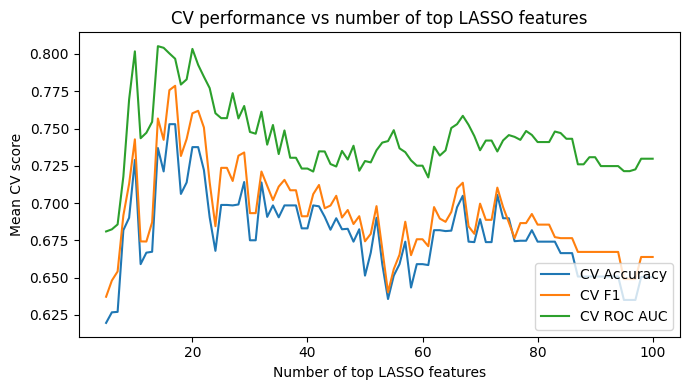

In [235]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1):
    top_feats = lasso_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features

In [236]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.5758
Precision: 0.6250
Recall:    0.5556
F1 score:  0.5882
ROC AUC:   0.6222


## Model XGB Features

In [237]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (XGB) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (XGB) on test:
Accuracy:  0.4848
Precision: 0.5263
Recall:    0.5556
F1 score:  0.5405
ROC AUC:   0.5037


## Model KBEST Features

In [238]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.5152
Precision: 0.5556
Recall:    0.5556
F1 score:  0.5556
ROC AUC:   0.6259


## Model LASSO Features

In [239]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.5758
Precision: 0.6111
Recall:    0.6111
F1 score:  0.6111
ROC AUC:   0.6593


## Model SHAP Features Tuning

In [251]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 166. Best value: 0.872527: 100%|██████████| 200/200 [00:09<00:00, 20.22it/s]



Best trial:
  Value: 0.8725274725274724
  Params:
    n_estimators: 141
    max_depth: 7
    learning_rate: 0.11524488100561456
    subsample: 0.6583678012824794
    colsample_bytree: 0.7509460579639549
    min_child_weight: 3.922869166722051
    gamma: 0.3233455013226192
    reg_lambda: 0.16776662725815342
    reg_alpha: 0.011580395609332989

Final Optuna model (SHAP):
Accuracy:  0.5758
Precision: 0.6111
Recall:    0.6111
F1 score:  0.6111
ROC AUC:   0.5852


## Model XGB Features Tuning

In [242]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (XGB):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 193. Best value: 0.825: 100%|██████████| 200/200 [00:14<00:00, 13.78it/s]   


Best trial:
  Value: 0.825
  Params:
    n_estimators: 52
    max_depth: 4
    learning_rate: 0.0550687189269296
    subsample: 0.5491768506886245
    colsample_bytree: 0.6049391768671066
    min_child_weight: 1.8906834134889123
    gamma: 1.0464388098020074
    reg_lambda: 0.011650608675741586
    reg_alpha: 0.42290134980536526

Final Optuna model (XGB):
Accuracy:  0.5455
Precision: 0.5882
Recall:    0.5556
F1 score:  0.5714
ROC AUC:   0.5889


## Model KBEST Features Tuning

In [244]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        scoring="f1",
        # scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 162. Best value: 0.80099: 100%|██████████| 200/200 [00:12<00:00, 16.43it/s] 


Best trial:
  Value: 0.8009902740937223
  Params:
    n_estimators: 86
    max_depth: 5
    learning_rate: 0.1596091633097666
    subsample: 0.5203098748208851
    colsample_bytree: 0.6090020770829059
    min_child_weight: 3.470921908504158
    gamma: 0.859270062392532
    reg_lambda: 0.6703574870500382
    reg_alpha: 0.014068898370330667

Final Optuna model (KBEST):
Accuracy:  0.6667
Precision: 0.7333
Recall:    0.6111
F1 score:  0.6667
ROC AUC:   0.7370


## Model LASSO Features Tuning

In [ ]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 187. Best value: 0.852473: 100%|██████████| 200/200 [00:11<00:00, 17.08it/s]



Best trial:
  Value: 0.8524725274725276
  Params:
    n_estimators: 115
    max_depth: 7
    learning_rate: 0.20060764114982568
    subsample: 0.5402433832486796
    colsample_bytree: 0.658581502112719
    min_child_weight: 1.244957694043494
    gamma: 0.0795396961600399
    reg_lambda: 0.05030758349680851
    reg_alpha: 0.04088371966416399

Final Optuna model (LASSO):
Accuracy:  0.7273
Precision: 0.7647
Recall:    0.7222
F1 score:  0.7429
ROC AUC:   0.7444


## Model SHAP Features Tuning + Early Stopping

In [252]:
# Feature selection
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna objective with CV + early stopping
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 40),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_aucs = []

    for train_idx, valid_idx in cv.split(X_train_fs, y_train):
        X_tr, X_val = X_train_fs.iloc[train_idx], X_train_fs.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params)

        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_val_pred = model.predict_proba(X_val)[:, 1]
        fold_auc = roc_auc_score(y_val, y_val_pred)
        fold_aucs.append(fold_auc)

    return np.mean(fold_aucs)


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params.copy()

# Extract early_stopping_rounds from tuned params
best_esr = best_params.pop("early_stopping_rounds", 30)

final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    early_stopping_rounds=best_esr,
    **best_params
)

# Use an internal validation split for early stopping
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
    X_train_fs, y_train, test_size=0.2, stratify=y_train, random_state=42
)

final_model.fit(
    X_tr_final,
    y_tr_final,
    eval_set=[(X_val_final, y_val_final)],
    verbose=False
)

# Evaluate on test set
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO + CV + Early Stopping):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 164. Best value: 0.901465: 100%|██████████| 200/200 [00:58<00:00,  3.39it/s]



Best trial:
  Value: 0.9014652014652015
  Params:
    n_estimators: 119
    max_depth: 7
    learning_rate: 0.11628137352870976
    subsample: 0.6943175301264971
    colsample_bytree: 0.7581675332960047
    min_child_weight: 3.5862308618248484
    gamma: 0.4855264580215824
    reg_lambda: 0.1304725355422806
    reg_alpha: 0.03076094239464498
    early_stopping_rounds: 39

Final Optuna model (LASSO + CV + Early Stopping):
Accuracy:  0.5758
Precision: 0.6000
Recall:    0.6667
F1 score:  0.6316
ROC AUC:   0.6241


## Model SHAP Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(140), 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Accuracy: 0.636 | ROC-AUC: 0.659

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(80), 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.545 | ROC-AUC: 0.641

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(120), 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.515 | ROC-AUC: 0.604

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(120), 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.485 | ROC-AUC: 0.615

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(100), 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.576 | ROC-AUC: 0.615

=== Testing top 10 featur

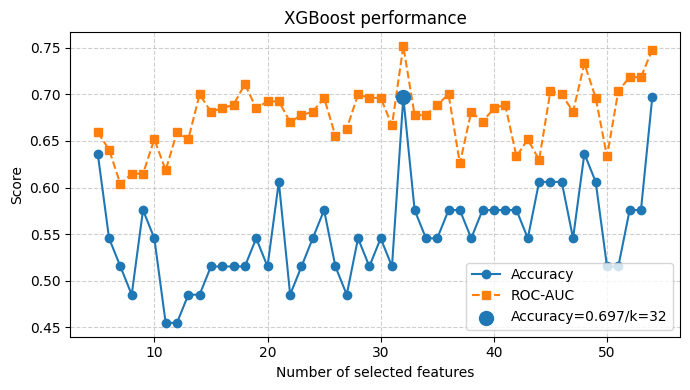


Accuracy = 0.697/ROC-AUC = 0.752/k = 32


In [ ]:
ranking = shap_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model XGB Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(140), 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.455 | ROC-AUC: 0.500

=== Testing top 6 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(60), 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Accuracy: 0.485 | ROC-AUC: 0.504

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(80), 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.545 | ROC-AUC: 0.507

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(100), 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Accuracy: 0.455 | ROC-AUC: 0.515

=== Testing top 9 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(60), 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.515 | ROC-AUC: 0.567

=== Testing top 10 feat

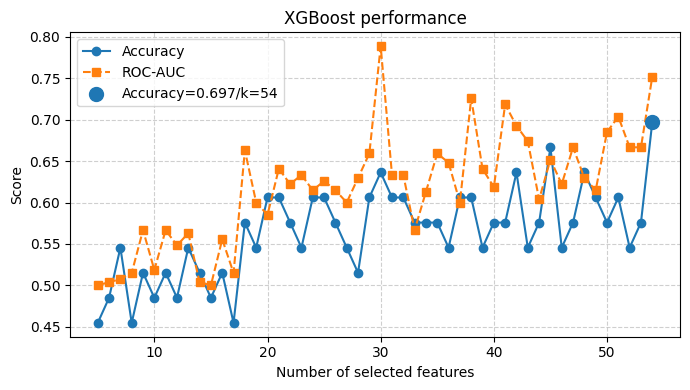


Accuracy = 0.697/ROC-AUC = 0.752/k = 54


In [ ]:
ranking = xgb_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(20), 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.636 | ROC-AUC: 0.693

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(140), 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.606 | ROC-AUC: 0.689

=== Testing top 7 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(100), 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Accuracy: 0.576 | ROC-AUC: 0.711

=== Testing top 8 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(60), 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.636 | ROC-AUC: 0.722

=== Testing top 9 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(80), 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.636 | ROC-AUC: 0.722

=== Testing top 10 features

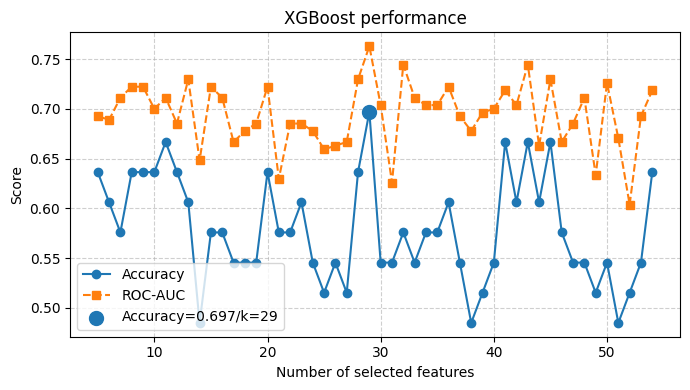


Accuracy = 0.697/ROC-AUC = 0.763/k = 29


In [ ]:
ranking = kbest_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(140), 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.606 | ROC-AUC: 0.756

=== Testing top 6 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(80), 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Accuracy: 0.667 | ROC-AUC: 0.696

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(80), 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Accuracy: 0.758 | ROC-AUC: 0.733

=== Testing top 8 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(40), 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Accuracy: 0.758 | ROC-AUC: 0.811

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(140), 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.697 | ROC-AUC: 0.737

=== Testing top 10 feature

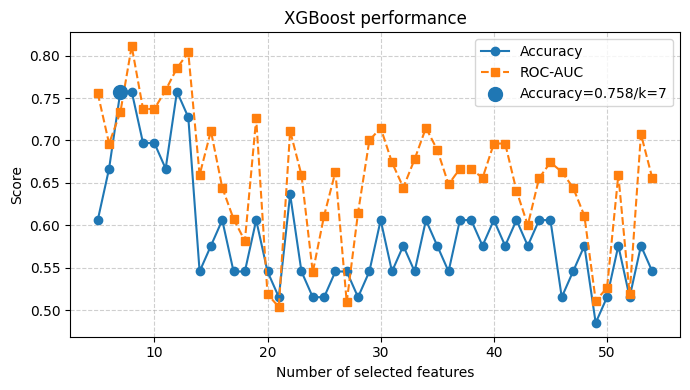


Accuracy = 0.758/ROC-AUC = 0.733/k = 7


In [ ]:
ranking = lasso_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")